<a href="https://colab.research.google.com/github/Ronin1289/Price-Predictor/blob/main/Price__Predictor_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM

##Importing Library

In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f2926bc47960dad958f0b033911111ad5a8c643cb3e7a37f85a5e47b70be05a0
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


##Loading Data

In [ ]:
def load_data(ticker, start, end, filename="BTC-USD_data.csv"):
    df = yf.download(ticker, start=start, end=end, auto_adjust=False)  # Ensure raw price data
    df['RSI'] = ta.momentum.RSIIndicator(pd.Series(df['Close'].squeeze()), window=14).rsi()  # Compute RSI
    df['RSI'] = df['RSI'].astype(float)  # Convert to 1D Series if needed
    df['Trend'] = df['Close'].pct_change().fillna(0)  # Compute trend
    df.dropna(inplace=True)  # Remove missing values

    # Save to CSV
    df.to_csv(filename, index=True)
    print(f"Data saved to {filename}")

    return df

# Load and save data
data = load_data("BTC-USD", start="2020-01-01", end="2024-01-01", filename="BTC-USD_data.csv")


[*********************100%***********************]  1 of 1 completed

Data saved to BTC-USD_data.csv


##Preparing Data

In [ ]:
# 2. Prepare Data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predicting close price
    return np.array(X), np.array(y)

# Load data
data = load_data("AAPL", start="2020-01-01", end="2024-01-01")

# Normalize features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Close', 'RSI', 'Volume', 'Trend']])

# Create sequences
seq_length = 70  # Using past 50 days
dataset_X, dataset_y = create_sequences(data_scaled, seq_length)

# Split data
train_size = int(len(dataset_X) * 0.8)
X_train, X_test = dataset_X[:train_size], dataset_X[train_size:]
y_train, y_test = dataset_y[:train_size], dataset_y[train_size:]


[*********************100%***********************]  1 of 1 completed

Data saved to BTC-USD_data.csv



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


##Building Model

In [ ]:

# 3. Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 4)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Predicting price
])

# Compile model
model.compile(optimizer='adam', loss='mse')


In [ ]:
from tensorflow.keras.optimizers import AdamW
model.compile(optimizer=AdamW(learning_rate=0.001), loss='mse')


##Training Model

In [ ]:
# Save weights after every epoch
checkpoint = ModelCheckpoint(
    "model_epoch_{epoch:02d}.weights.h5",
    save_weights_only=True,
    save_freq='epoch'
)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),callbacks=[checkpoint])


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0017 - val_loss: 6.2672e-04
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0013 - val_loss: 8.8308e-04
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0012 - val_loss: 5.1245e-04
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0016 - val_loss: 0.0036


##Analyzing Performance

In [ ]:
from sklearn.metrics import r2_score

# Get model predictions
y_pred = model.predict(X_test)

# Inverse transform to get actual price values
y_test_actual = scaler.inverse_transform(np.column_stack((y_test, np.zeros((len(y_test), 3)))))[:, 0]
y_pred_actual = scaler.inverse_transform(np.column_stack((y_pred.flatten(), np.zeros((len(y_pred), 3)))))[:, 0]

# Compute R² Score
r2 = r2_score(y_test_actual, y_pred_actual)

# Print R² Score (Accuracy)
print(f"Model Accuracy (R² Score): {r2:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Model Accuracy (R² Score): 0.1878


In [ ]:
epoch_to_load = 7
weights_path = f"model_epoch_{epoch_to_load:02d}.weights.h5"
model.load_weights(weights_path)

print(f"Loaded weights from epoch {epoch_to_load}")


Loaded weights from epoch 7


In [ ]:
from sklearn.metrics import r2_score

# Get model predictions
y_pred = model.predict(X_test)

# Inverse transform to get actual price values
y_test_actual = scaler.inverse_transform(np.column_stack((y_test, np.zeros((len(y_test), 3)))))[:, 0]
y_pred_actual = scaler.inverse_transform(np.column_stack((y_pred.flatten(), np.zeros((len(y_pred), 3)))))[:, 0]

# Compute R² Score
r2 = r2_score(y_test_actual, y_pred_actual)

# Print R² Score (Accuracy)
print(f"Model Accuracy (R² Score): {r2:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Model Accuracy (R² Score): 0.7382


In [ ]:
from sklearn.metrics import r2_score

# Baseline prediction: Yesterday's closing price as today's prediction
y_baseline = X_test[:, -1, 0]  # Last known "Close" price in each sequence

# Compare naive prediction vs actual
r2_baseline = r2_score(y_test, y_baseline)
r2_model = r2_score(y_test, y_pred)

# Print evaluation
if r2_model > r2_baseline:
    print("✅ Model is performing better than the baseline.")
else:
    print("❌ Model is worse than simply guessing the previous close price.")


❌ Model is worse than simply guessing the previous close price.


In [ ]:
print("Baseline R² Score:", r2_baseline)


Baseline R² Score: 0.9458917481400232


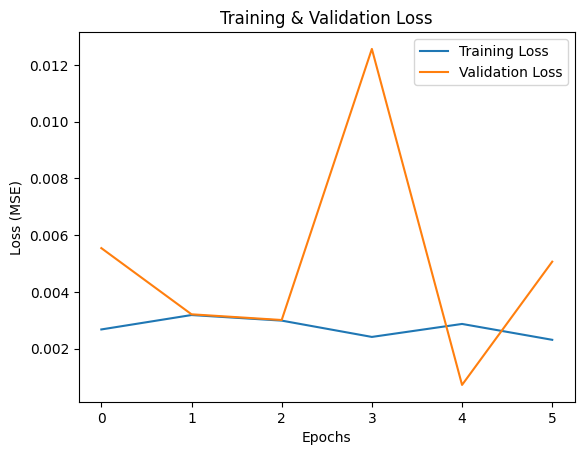

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Mean Absolute Error (MAE): 9.41
Root Mean Squared Error (RMSE): 10.11
R² Score: -0.25


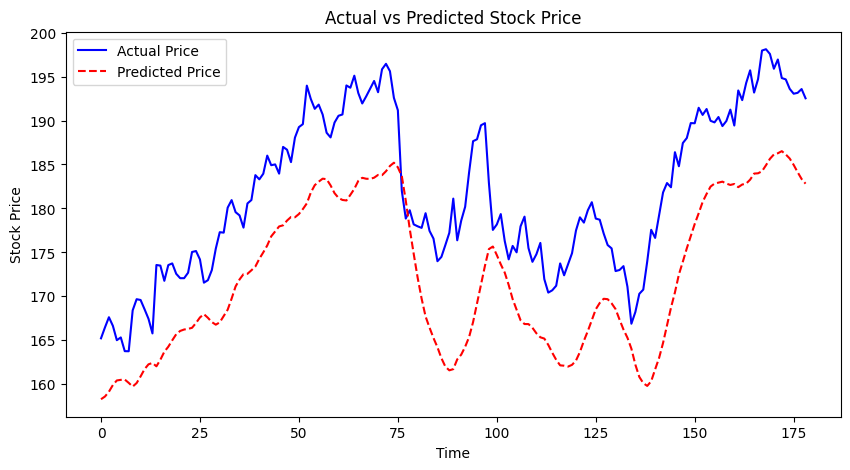

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Evaluate training and validation loss
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

# Get predictions
y_pred = model.predict(X_test)

# Inverse transform to get actual price values
y_test_actual = scaler.inverse_transform(np.column_stack((y_test, np.zeros((len(y_test), 3)))))[:, 0]
y_pred_actual = scaler.inverse_transform(np.column_stack((y_pred.flatten(), np.zeros((len(y_pred), 3)))))[:, 0]

# Compute Evaluation Metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label="Actual Price", color='blue')
plt.plot(y_pred_actual, label="Predicted Price", color='red', linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Actual vs Predicted Stock Price")
plt.show()
